# 2009-SAGMB-Detecting Outlier Samples in Microarray Data

"The MAS-4 software combines the PM and MM values by subtracting MM from PM values, so it is possible for gene expression to be negative, which means that MM probes have stronger signals than PM. Since we do not know what is matching the MM probes, these signals are not useful, and for this  reason, data processed with MAS-4 software is heuristically set to a minimum of 20. Affymetrix MAS-5 software does not generate negative expression values and does its own thresholding." [1]

"The small, round blue cell tumor (SRBCT) data set (Khan et. al., 2001) contains 63 samples, of which 23 samples are from the Ewing family of tumors (EWS), 20 samples are from rhabdomyosarcoma (RMS), 12 samples are from neuroblastoma (NB), and 8 samples are from Burkitt lymphoma (BL).
Expression levels for 6,567 genes were measured using glass slide cDNA microarrays. The data set was filtered down to the 2,308 genes with sufficient red intensity across all of the samples." [2]

"Since each class in a data set has a different underlying distribution, we treat each class as an independent data set for the purpose of outlier detection" [2]

"We applied a base-2 logarithm transformation and quantile transformation to both data sets. No scaling was applied to the genes or the samples since we do not want to treat inliner and outlier samples or informative and non-inofrmative genes equally." [2]

Reference:

[1]G. Piatetsky-Shapiro, T. Khabaza, and S. Ramaswamy, “Capturing best practice for microarray gene expression data analysis,” in Proceedings of the Ninth ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, in KDD ’03. New York, NY, USA: Association for Computing Machinery, 2003, pp. 407–415. doi: 10.1145/956750.956797.

[2]A. D. Shieh and Y. S. Hung, “Detecting Outlier Samples in Microarray Data,” Statistical Applications in Genetics and Molecular Biology, vol. 8, no. 1, pp. 1–24, Jan. 2009, doi: 10.2202/1544-6115.1426.
  

hat_q 2
Chi-Square Threshold: 7.38


MED   0.49
MGL   0.43
RHB   0.43
EPD   0.45
Name: Breakdown Points, dtype: float64

,Outlier Indexes,Outlier Percentages,Total Samples
MED,"[15, 17]",5.13,39
MGL,"[40, 45]",28.57,7
RHB,[53],14.29,7
EPD,"[54, 55, 59, 60]",40.00,10
JPA,[],0.00,6


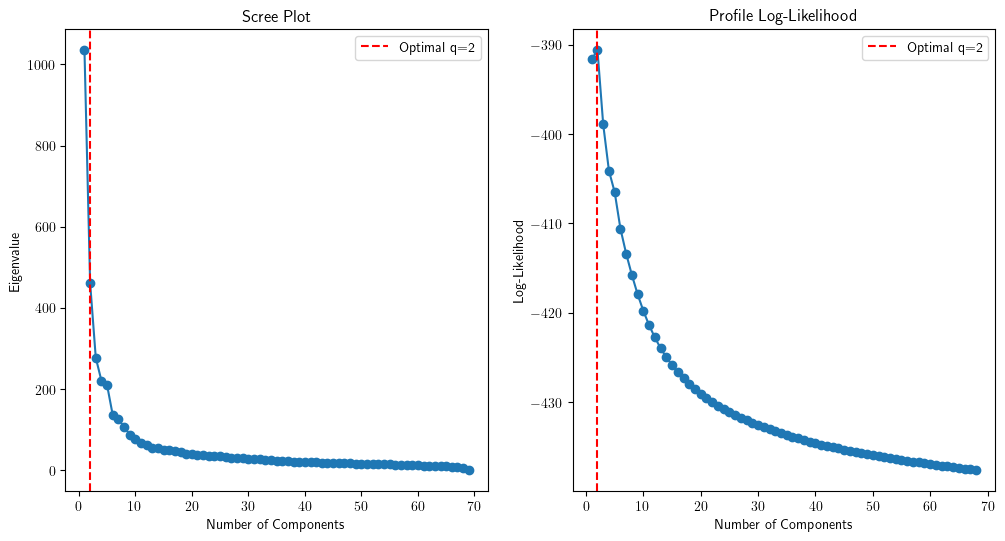

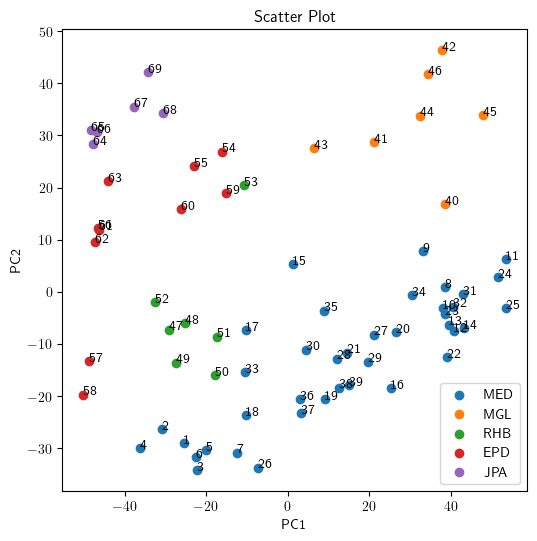

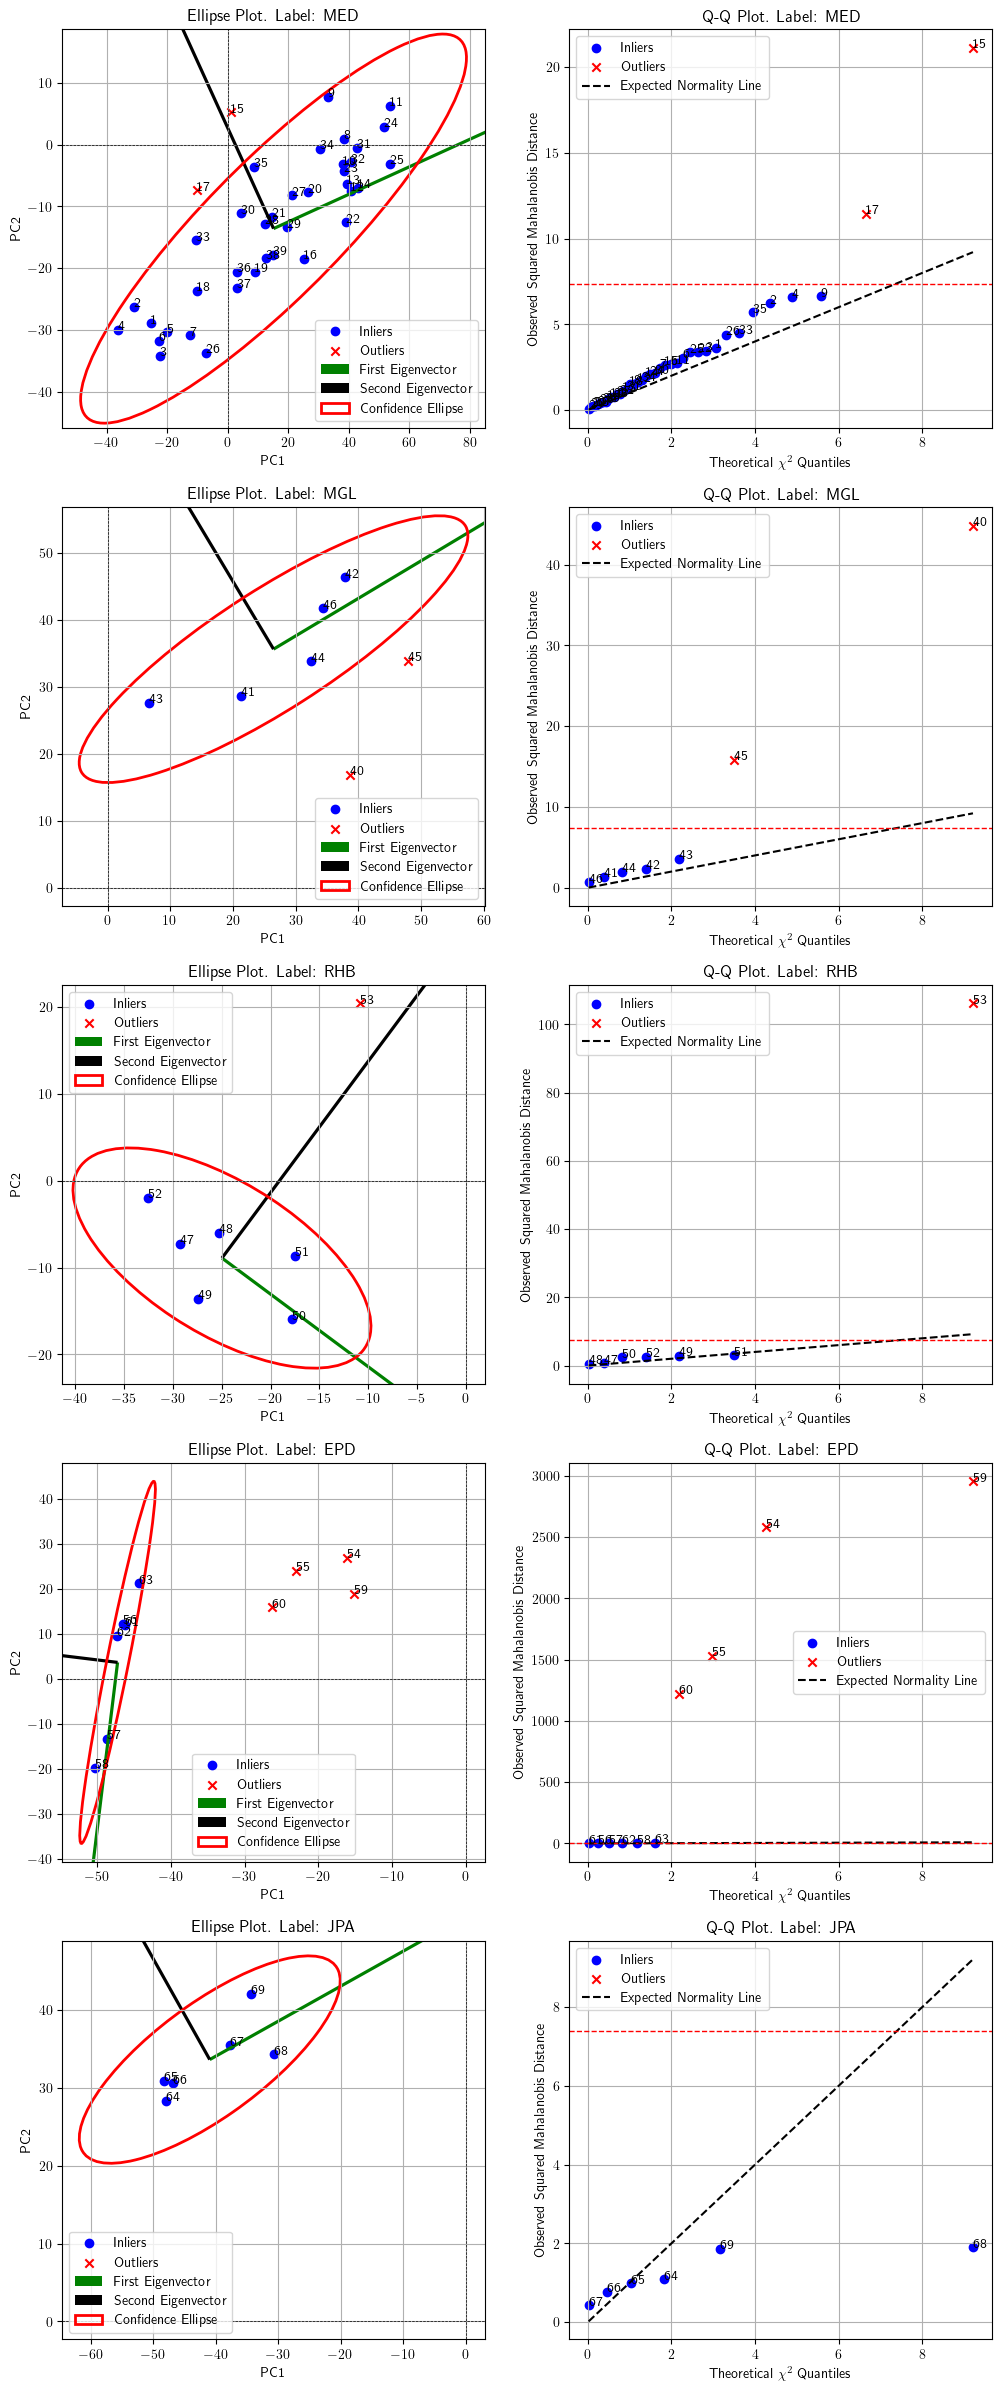

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.covariance import MinCovDet
from scipy.stats import chi2

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
plt.rcParams.update({'text.usetex': True})
pd.options.display.float_format = '{:.2f}'.format

# Step 1: Load the microarray data
X_train = pd.read_csv("../datasets/pp5i_train.gr.csv").set_index("SNO").rename_axis(None, axis=0)
y_train = pd.read_csv("../datasets/pp5i_train_class.txt").set_index(X_train.T.index)

# Step 2: Clipping the data 
# because the datasets was processed with MAS-4 software which generate negative values,
# and values below 100 are less reproducible and above 16,000 tend to have non-linear correlation with the actual gene expression.
# For dataset with more noise, lower bound of 100 is used.
X_train_clipped = X_train.copy().clip(20, 16000)

# Step 3: Filter genes based on maximum-to-minimum ratio
# because many genes are not vary enough to be informative.
X_train_filtered = X_train_clipped.copy()
ratio = X_train_filtered.max(axis=1) / X_train_filtered.min(axis=1)
X_train_filtered = X_train_filtered[ratio > 2]

# Step 4: Transforming the data with log2 
# because the assumption is that
# genes with high values tend to have a higher variance
# while genes with low values tend to have lower variance.
# This makes it difficult to compare genes 
# because the variance depends on the values level.
# Log2 makes the variance uniform across different values level.
X_train_log2 = X_train_filtered.copy().astype(float).apply(lambda x: np.log2(x + 1))

# Step 5: Normalizing the data with quantile normalization 
# to make the data comparable across different samples
# by making the distribution of each sample uniform.
def quantile_normalize(df: pd.DataFrame):
    """
    Reference: 
    2003-Bioinformatics-A Comparison of Normalization Methods for High Density Oligonucleotide Array Data Based on Variance and Bias
    """
    sorted_matrix = np.sort(df.values, axis=0)
    rank_means = np.mean(sorted_matrix, axis=1)
    df_normalized = pd.DataFrame(0.0, index=df.index, columns=df.columns)
    for i in range(df.shape[1]): # Iterate over each sample (column)
        ranks = np.argsort(np.argsort(df.iloc[:, i].values)) # Get ranks
        df_normalized.iloc[:, i] = rank_means[ranks] # Assign mean to original ranks
    return df_normalized

X_train_normalized = quantile_normalize(X_train_log2.copy())

# Step 6: Calculate the optimal number of components for PCA
def estimate_hat_q(eigenvalues: np.ndarray):
  """
  Reference:
  2006-CSDA-Automatic dimensionality selection from the scree plot via the use of profile likelihood

  It is important to note that robust estimators become unreliable for small sample sizes, especially when, n < 2p,
  because the weighting of each sample becomes highly influential towards the estimates"
  where n = # samples, p = # features
  """
  p = len(eigenvalues)

  log_likelihoods = np.zeros(p - 1)

  for q in range(1, p):
    S_1 = eigenvalues[:q]
    S_2 = eigenvalues[q:]

    mu_1 = np.mean(S_1)
    mu_2 = np.mean(S_2)
    sigma_squared = ( np.sum((S_1 - mu_1) ** 2) + np.sum((S_2 - mu_2) ** 2) ) / (p - 2)

    log_likelihood = (- 1 / (2 * sigma_squared) * (np.sum((S_1 - mu_1) ** 2)
                                                   + np.sum((S_2 - mu_2) ** 2))
                     - (p / 2) * np.log(2 * np.pi * sigma_squared))
    
    log_likelihoods[q - 1] = log_likelihood

  hat_q = np.argmax(log_likelihoods) + 1 # +1 to account for 0-based indexing
  return hat_q, log_likelihoods

def plot_scree(ax: plt.Axes, eigenvalues: np.ndarray, hat_q: int):
  ax.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', linestyle='-')
  ax.set_title("Scree Plot")
  ax.set_xlabel("Number of Components")
  ax.set_ylabel("Eigenvalue")
  ax.axvline(hat_q, color='r', linestyle='--', label=f'Optimal q={hat_q}')
  ax.legend()

def plot_profile_log_likelihood(ax: plt.Axes, log_likelihoods: np.ndarray, hat_q: int):
  ax.plot(range(1, len(log_likelihoods) + 1), log_likelihoods, marker='o', linestyle='-')
  ax.set_title("Profile Log-Likelihood")
  ax.set_xlabel("Number of Components")
  ax.set_ylabel("Log-Likelihood")
  ax.axvline(hat_q, color='r', linestyle='--', label=f'Optimal q={hat_q}')
  ax.legend()

def plot_scatter(ax: plt.Axes, X: pd.DataFrame, y: pd.Series):
  for class_name in y.unique():
    X_class = X[y == class_name]
    ax.scatter(X_class.iloc[:, 0], X_class.iloc[:, 1], label=class_name)
    for x_i_name, x_i in X_class.iterrows():
      ax.annotate(x_i_name, (x_i[0], x_i[1]))
  
  ax.set_xlabel("PC1")
  ax.set_ylabel("PC2")
  ax.set_title("Scatter Plot")
  ax.legend()

pca = PCA().fit(X_train_normalized.T) # note: use pca_optimal for transforming the data
hat_q, log_likelihoods = estimate_hat_q(pca.explained_variance_)
print("hat_q", hat_q)
pca_optimal = PCA(n_components=hat_q).fit(X_train_normalized.T)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plot_scree(axes[0], pca.explained_variance_, hat_q)
plot_profile_log_likelihood(axes[1], log_likelihoods, hat_q)

fig, axes = plt.subplots(1, 1, figsize=(6, 6))
plot_scatter(axes, pd.DataFrame(pca_optimal.transform(X_train_normalized.T), index=X_train_normalized.columns), y_train["Class"])

# Step 7: Splitting the data into different classes
# because each class in the dataset has different distribution.
Xy_train = pd.concat([X_train_normalized.T, y_train], axis=1)
X_train_MED = Xy_train[Xy_train["Class"] == "MED"].copy().drop(columns=["Class"])
X_train_MGL = Xy_train[Xy_train["Class"] == "MGL"].copy().drop(columns=["Class"])
X_train_RHB = Xy_train[Xy_train["Class"] == "RHB"].copy().drop(columns=["Class"])
X_train_EPD = Xy_train[Xy_train["Class"] == "EPD"].copy().drop(columns=["Class"])
X_train_JPA = Xy_train[Xy_train["Class"] == "JPA"].copy().drop(columns=["Class"])

# Step 8: Transform the data with PCA.
X_train_MED_pc = pd.DataFrame(pca_optimal.transform(X_train_MED), index=X_train_MED.index)
X_train_MGL_pc = pd.DataFrame(pca_optimal.transform(X_train_MGL), index=X_train_MGL.index)
X_train_RHB_pc = pd.DataFrame(pca_optimal.transform(X_train_RHB), index=X_train_RHB.index)
X_train_EPD_pc = pd.DataFrame(pca_optimal.transform(X_train_EPD), index=X_train_EPD.index)
X_train_JPA_pc = pd.DataFrame(pca_optimal.transform(X_train_JPA), index=X_train_JPA.index)

# Step 9: Outlier Detection.

# Calculate the threshold
chi_square_threshold = chi2.ppf(0.975, df=hat_q) # we are defining an ellipse that contains 97.5% of the data
print("Chi-Square Threshold: %.2f" % chi_square_threshold)

# Calculate the breakdown point
# number of samples with JPA classes are too small, so we will use sample mean and covariance
MED_breakdown_point = ((len(X_train_MED_pc) - hat_q + 1) / 2) / len(X_train_MED_pc)
MGL_breakdown_point = ((len(X_train_MGL_pc) - hat_q + 1) / 2) / len(X_train_MGL_pc)
RHB_breakdown_point = ((len(X_train_RHB_pc) - hat_q + 1) / 2) / len(X_train_RHB_pc)
EPD_breakdown_point = ((len(X_train_EPD_pc) - hat_q + 1) / 2) / len(X_train_EPD_pc)
breakdown_points = pd.Series([MED_breakdown_point, MGL_breakdown_point, RHB_breakdown_point, EPD_breakdown_point],
                              index=["MED", "MGL", "RHB", "EPD"],
                              name="Breakdown Points")
display(breakdown_points)

MED_mcd = MinCovDet(support_fraction=MED_breakdown_point, random_state=0).fit(X_train_MED_pc)
MGL_mcd = MinCovDet(support_fraction=MGL_breakdown_point, random_state=0).fit(X_train_MGL_pc)
RHB_mcd = MinCovDet(support_fraction=RHB_breakdown_point, random_state=0).fit(X_train_RHB_pc)
EPD_mcd = MinCovDet(support_fraction=EPD_breakdown_point, random_state=0).fit(X_train_EPD_pc)

# Calculate the squared Mahalanobis distances
def mahalanobis_distance(x_i: np.ndarray, mu: int, C: np.ndarray) -> float:
  """
  Reference:
  https://www.youtube.com/watch?v=ayfr6KN4Jd0
  """  
  return np.sqrt((x_i - mu).T @ np.linalg.inv(C) @ (x_i - mu))

MED_squared_mahalanobis_distances = pd.Series(MED_mcd.mahalanobis(X_train_MED_pc), index=X_train_MED_pc.index)
MGL_squared_mahalanobis_distances = pd.Series(MGL_mcd.mahalanobis(X_train_MGL_pc), index=X_train_MGL_pc.index)
RHB_squared_mahalanobis_distances = pd.Series(RHB_mcd.mahalanobis(X_train_RHB_pc), index=X_train_RHB_pc.index)
EPD_squared_mahalanobis_distances = pd.Series(EPD_mcd.mahalanobis(X_train_EPD_pc), index=X_train_EPD_pc.index)
JPA_squared_mahalanobis_distances = pd.Series(X_train_JPA_pc.apply(lambda x_i: mahalanobis_distance(x_i, X_train_JPA_pc.mean(), X_train_JPA_pc.cov(ddof=1)), axis=1), 
                                              index=X_train_JPA_pc.index)

def plot_ellipse(ax: plt.Axes, 
                 X: pd.DataFrame, squared_mahalanobis_distances: pd.Series, 
                 cov: np.ndarray,
                 chi_square_threshold: float,
                 label: str):
  inliers = X[(squared_mahalanobis_distances <= chi_square_threshold)]
  outliers = X[(squared_mahalanobis_distances > chi_square_threshold)]

  ax.scatter(inliers.iloc[:, 0], inliers.iloc[:, 1], label="Inliers", c='b', marker='o')
  ax.scatter(outliers.iloc[:, 0], outliers.iloc[:, 1], label="Outliers", c='r', marker='x')

  inliers_mu = inliers.mean(axis=0)
  eigenvalues, eigenvectors = np.linalg.eig(cov)
  order = eigenvalues.argsort()[::-1]
  sorted_eigenvalues, sorted_eigenvectors = eigenvalues[order], eigenvectors[:, order]
  ax.quiver(inliers_mu[0], inliers_mu[1], 
            sorted_eigenvectors[0, 0], sorted_eigenvectors[1, 0], 
            color='green', scale=1, label="First Eigenvector")
  ax.quiver(inliers_mu[0], inliers_mu[1], 
            sorted_eigenvectors[0, 1], sorted_eigenvectors[1, 1], 
            color='black', scale=1, label="Second Eigenvector")
  
  ellipse = Ellipse(xy=inliers_mu, 
                    width=2 * np.sqrt(chi_square_threshold * sorted_eigenvalues[0]),
                    height=2 * np.sqrt(chi_square_threshold * sorted_eigenvalues[1]), 
                    angle=np.degrees(np.arctan2(*sorted_eigenvectors[:, 0][::-1])), 
                    edgecolor='r', fc='None', linewidth=2, label="Confidence Ellipse")
  ax.add_patch(ellipse)

  for x_i_name, x_i in X.iterrows():
    ax.annotate(x_i_name, (x_i[0], x_i[1]))

  ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
  ax.axvline(x=0, color='black', linestyle='--', linewidth=0.5)
  ax.set_xlabel("PC1")
  ax.set_ylabel("PC2")
  ax.set_title("Ellipse Plot. Label: %s" % label)
  ax.legend()
  ax.grid(True)

def plot_qqplot(ax: plt.Axes, squared_mahalanobis_distances: pd.Series, label: str):
  sorted_squared_mahalanobis_distances = squared_mahalanobis_distances.sort_values(ascending=True)
  chi2_quantiles = chi2.ppf(np.linspace(0.01, 0.99, len(sorted_squared_mahalanobis_distances)), df=2)
  
  inliers = sorted_squared_mahalanobis_distances[sorted_squared_mahalanobis_distances <= chi_square_threshold]
  inliers_length = len(inliers)
  outliers = sorted_squared_mahalanobis_distances[sorted_squared_mahalanobis_distances > chi_square_threshold]
  
  ax.scatter(chi2_quantiles[:inliers_length], inliers, color='b', label="Inliers", marker='o')
  ax.scatter(chi2_quantiles[inliers_length:], outliers, color='r', label="Outliers", marker='x')
  
  ax.plot(chi2_quantiles, chi2_quantiles, linestyle='dashed', color='black', label='Expected Normality Line')

  ax.axhline(y=chi_square_threshold, color='red', linestyle='--', linewidth=1)

  ax.set_xlabel("Theoretical $\chi^2$ Quantiles")
  ax.set_ylabel("Observed Squared Mahalanobis Distance")
  ax.set_title(("Q-Q Plot. Label: %s" % label))
  ax.legend()
  ax.grid(True)

  for i in range(0, len(sorted_squared_mahalanobis_distances)):
    index_name = sorted_squared_mahalanobis_distances.index[i]
    squared_mahalanobis_distance = sorted_squared_mahalanobis_distances.iloc[i]
    ax.annotate(index_name, (chi2_quantiles[i], squared_mahalanobis_distance))

fig, axes = plt.subplots(5, 2, figsize=(12, 30))
plot_ellipse(axes[0][0], X_train_MED_pc, MED_squared_mahalanobis_distances, MED_mcd.covariance_, chi_square_threshold, "MED")
plot_ellipse(axes[1][0], X_train_MGL_pc, MGL_squared_mahalanobis_distances, MGL_mcd.covariance_, chi_square_threshold, "MGL")
plot_ellipse(axes[2][0], X_train_RHB_pc, RHB_squared_mahalanobis_distances, RHB_mcd.covariance_, chi_square_threshold, "RHB")
plot_ellipse(axes[3][0], X_train_EPD_pc, EPD_squared_mahalanobis_distances, EPD_mcd.covariance_, chi_square_threshold, "EPD")
plot_ellipse(axes[4][0], X_train_JPA_pc, JPA_squared_mahalanobis_distances, X_train_JPA_pc.cov(ddof=1), chi_square_threshold, "JPA")
plot_qqplot(axes[0][1], MED_squared_mahalanobis_distances, "MED")
plot_qqplot(axes[1][1], MGL_squared_mahalanobis_distances, "MGL")
plot_qqplot(axes[2][1], RHB_squared_mahalanobis_distances, "RHB")
plot_qqplot(axes[3][1], EPD_squared_mahalanobis_distances, "EPD")
plot_qqplot(axes[4][1], JPA_squared_mahalanobis_distances, "JPA")

MED_outliers = X_train_MED_pc[MED_squared_mahalanobis_distances > chi_square_threshold]
MGL_outliers = X_train_MGL_pc[MGL_squared_mahalanobis_distances > chi_square_threshold]
RHB_outliers = X_train_RHB_pc[RHB_squared_mahalanobis_distances > chi_square_threshold]
EPD_outliers = X_train_EPD_pc[EPD_squared_mahalanobis_distances > chi_square_threshold]
JPA_outliers = X_train_JPA_pc[JPA_squared_mahalanobis_distances > chi_square_threshold]

outliers = pd.DataFrame({"Outlier Indexes": [MED_outliers.index.values, MGL_outliers.index.values, RHB_outliers.index.values, EPD_outliers.index.values, JPA_outliers.index.values],
                         "Outlier Percentages": [(len(MED_outliers) / len(X_train_MED_pc) * 100),
                                                 (len(MGL_outliers) / len(X_train_MGL_pc) * 100),
                                                 (len(RHB_outliers) / len(X_train_RHB_pc) * 100),
                                                 (len(EPD_outliers) / len(X_train_EPD_pc) * 100),
                                                 (len(JPA_outliers) / len(X_train_JPA_pc) * 100)],
                         "Total Samples": [len(X_train_MED_pc), len(X_train_MGL_pc), len(X_train_RHB_pc), len(X_train_EPD_pc), len(X_train_JPA_pc)]},
                        index=["MED", "MGL", "RHB", "EPD", "JPA"])
display(outliers)

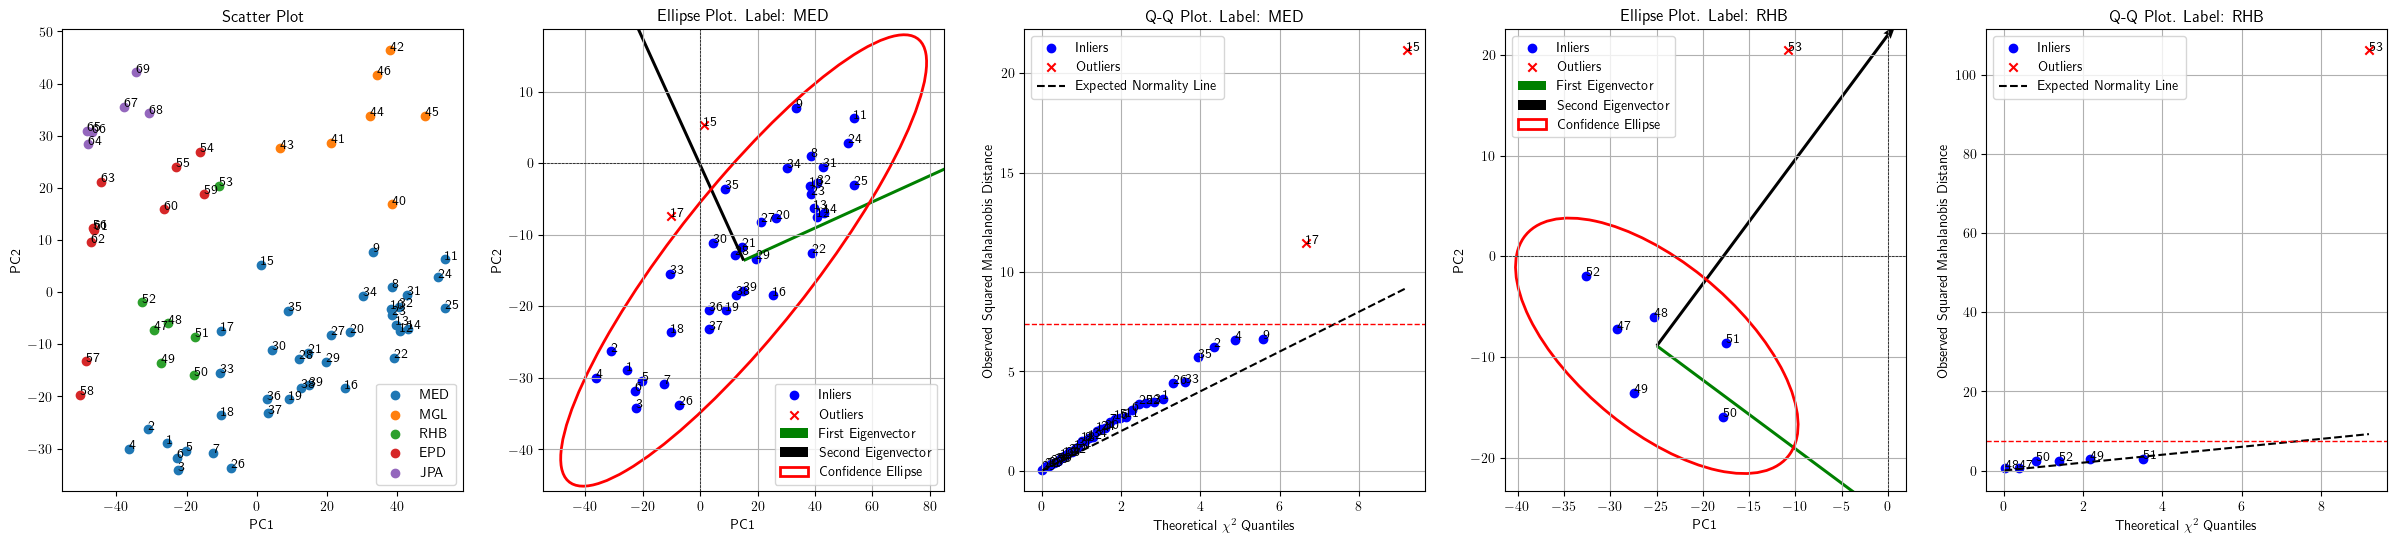

In [9]:
fig, axes = plt.subplots(1, 5, figsize=(30, 6))

plot_scatter(axes[0], pd.DataFrame(pca_optimal.transform(X_train_normalized.T), index=X_train_normalized.columns), y_train["Class"])
plot_ellipse(axes[1], X_train_MED_pc, MED_squared_mahalanobis_distances, MED_mcd.covariance_, chi_square_threshold, "MED")
plot_qqplot(axes[2], MED_squared_mahalanobis_distances, "MED")
plot_ellipse(axes[3], X_train_RHB_pc, RHB_squared_mahalanobis_distances, RHB_mcd.covariance_, chi_square_threshold, "RHB")
plot_qqplot(axes[4], RHB_squared_mahalanobis_distances, "RHB")

# Mahalanobis Distance

"The classical measure of the outlyingness of a sample x_i is the Malahanobis distance. $d(x_i) = \sqrt{(x_i - \mu)'C^{-1} (x - t)}$ where t and C are the sample mean and covariance. However, it is well known that the sample mean and covariance are highly suspectible to outliers. Although Mahalanobis distances can detect single outliers,  they breakdown in the presence of multiple outliers due to the masking effect, where multiple outliers will not all have large Mahalanobis distances (Rousseeuw and Leroy, 1986). Therefore, it is necessary to use a robust version of the Mahalanobis distance,  which is often referred to as the robust distance, using robust estimates of the mean and covariance." [1]

- $(x_i - t)$ is a column vector of shape $(p,1)$ (where $p$ is the number of dimensions).
- The covariance matrix $C^{-1}$ has shape $(p,p)$.
- We transpose $(x_i -t)$ to make it a row vector $(1,p)$, ensuring valid matrix multiplication.

Reference:

[1]A. D. Shieh and Y. S. Hung, “Detecting Outlier Samples in Microarray Data,” Statistical Applications in Genetics and Molecular Biology, vol. 8, no. 1, pp. 1–24, Jan. 2009, doi: 10.2202/1544-6115.1426.
  

In [3]:
import pandas as pd

df = pd.DataFrame({"Infection": ["Viral", "Viral", "Viral", "Viral", "Viral", "Viral", "Bacterial", "Bacterial", "Bacterial", "Bacterial", "Bacterial", "Bacterial"],
                   "CRP (mg/L)": [42, 57, 38, 43, 30, 58, 61, 70, 55, 74, 56, 72],
                   "PCT (μg/L)": [33, 29, 39, 40, 45, 39, 67, 60, 62, 75, 55, 70]})

centroid = df.groupby("Infection").mean()
cov = df.groupby("Infection").cov()

def mahalanobis_distance(x_i: np.ndarray, mu: int, C: np.ndarray) -> float:
  """
  Reference:
  https://www.youtube.com/watch?v=ayfr6KN4Jd0
  """  
  return np.sqrt((x_i - mu).T @ np.linalg.inv(C) @ (x_i - mu))

print("mahalanobis distance between the viral centroid and data point [49, 49]     \t = %s" % (mahalanobis_distance([49, 49], centroid.loc["Viral"], cov.loc["Viral"])).round(2))
print("mahalanobis distance between the bacterial centroid and data point [49, 49] \t = %s" % (mahalanobis_distance([49, 49], centroid.loc["Bacterial"], cov.loc["Bacterial"])).round(2))

mahalanobis distance between the viral centroid and data point [49, 49]     	 = 3.0
mahalanobis distance between the bacterial centroid and data point [49, 49] 	 = 2.24


chi-square threshold: 7.38
squared_mahalanobis_distances [0.81 0.7  0.86 4.   1.57 1.87 2.2 ]
outliers: [False False False False False False False]
sorted eigenvalues: [3936.86   42.38]
sorted eigenvectors: [[-0.69 -0.72]
 [-0.72  0.69]]
angle: -133.78764769742892


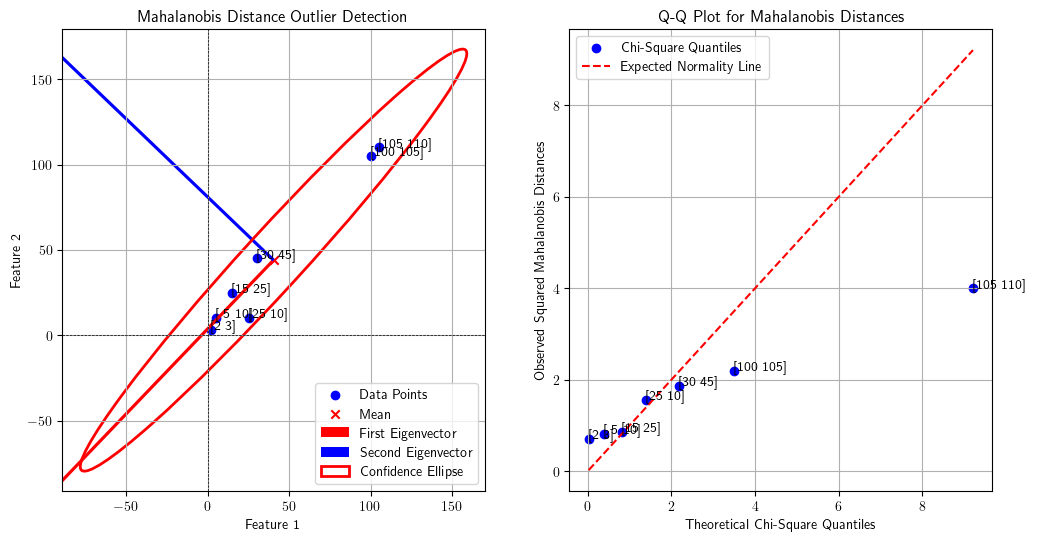

In [4]:
import numpy as np
from scipy.stats import chi2

from matplotlib.patches import Ellipse

# each row is a sample and each column is a feature
X = np.array([[2,3],
              [5,10],
              [15,25],
              [25,10],
              [30,45],
              [100,105],  # Outlier
              [105,110]]) # Outlier

mu = np.mean(X, axis=0) # mean of each feature
cov = np.cov(X, rowvar=False)

# Compute Mahalanobis Distance
squared_mahalanobis_distances = np.array([])
for x_i in X:
  squared_mahalanobis_distances = np.append(squared_mahalanobis_distances, mahalanobis_distance(x_i, mu, cov) ** 2)

# Chi-square threshold for p = 0.975 and df = 2 (since 2 features)
# which ensures that only 2.5% of the points are falsely flagged as outliers,
# assuming the dataset follows a multivariate normal distribution.
# Therefore, the limitation is that the dataset must be normally distributed.
# If the dataset is skewed, then even valid data points may have high Mahalanobis distances.
# Consequently, some valid data points may be flagged as outliers.
# The Mahalanobis distance follows a chi-square distribution with degrees of freedom
# equal to the number of features.
chi_square_threshold = chi2.ppf(0.975, df=2) # we are defining an ellipse that contains 97.5% of the data

print("chi-square threshold:", chi_square_threshold.round(2))
print("squared_mahalanobis_distances", squared_mahalanobis_distances.round(2))
print("outliers:", squared_mahalanobis_distances > chi_square_threshold)

# Eigenvalues and Eigenvectors for the ellipse orientation
# Eigenvalues are the variance of the data along the eigenvectors
# Eigenvectors are the direction of the variance
eigenvalues, eigenvectors = np.linalg.eig(cov)

# Sort Eigenvalues and Eigenvectors in descending order
order = eigenvalues.argsort()[::-1]
sorted_eigenvalues, sorted_eigenvectors = eigenvalues[order], eigenvectors[:, order]
print("sorted eigenvalues:", sorted_eigenvalues.round(2))
print("sorted eigenvectors:", sorted_eigenvectors.round(2))

# Compute the Angle for the ellipse orientation (in degrees)
# eigenvectors[:, 0] is the first principal component (direction of max variance)
# [::-1] flips from [x,y] to [y,x] because the angle is measured from the x-axis
# np.arctan2 gives the angle in radians, computes the angle relative to the x-axis
# np.degrees converts the angle to degrees
angle = np.degrees(np.arctan2(*sorted_eigenvectors[:, 0][::-1]))
print("angle:", angle)

# Eigenvalues are variances (squared units of spread)
# Taking the square root gives standard deviation, which is a measure of spread in the actual unit
# Multiplying by np.sqrt(chi2_square_threshold) scales the spread based on the chosen confidence level
# Multiplying by 2 emsures the ellipse covers the full width (from leftmost to rightmost point).
width, height = 2 * np.sqrt(chi_square_threshold * sorted_eigenvalues)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the data points
axes[0].scatter(X[:, 0], X[:, 1], label="Data Points", color='b')

# Highlight the mean center
axes[0].scatter(mu[0], mu[1], label="Mean", color='r', marker='x')

# Plot eigenvectors
# The new main X-axis of the data (rotated from the original X-axis)
axes[0].quiver(mu[0], mu[1], 
          sorted_eigenvectors[0, 0], sorted_eigenvectors[1, 0], 
          color='red', scale=1, label="First Eigenvector")

# The new secondary Y-axis of the data (rotated from the original Y-axis)
axes[0].quiver(mu[0], mu[1], 
          sorted_eigenvectors[0, 1], sorted_eigenvectors[1, 1], 
          color='blue', scale=1, label="Second Eigenvector")

# Add the confidence ellipse
ellipse = Ellipse(xy=mu, width=width, height=height, angle=angle, edgecolor='r', fc='None', linewidth=2, label="Confidence Ellipse")
axes[0].add_patch(ellipse)

# Annotate the data points
for i, txt in enumerate(X):
  axes[0].annotate(txt, (X[i, 0], X[i, 1]))

# Plot Settings
axes[0].axhline(y=0, color='black', linestyle="--", linewidth=0.5)
axes[0].axvline(x=0, color='black', linestyle="--", linewidth=0.5)
axes[0].set_xlabel("Feature 1")
axes[0].set_ylabel("Feature 2")
axes[0].set_title("Mahalanobis Distance Outlier Detection")
axes[0].legend()
axes[0].grid(True)

# Create Q-Q plot
# Check if dataset follows a chi-square distribution $d_M^2 \sim \chi^2$

## Compute squared Mahalanobis distances (should follow a chi-square distribution)
sorted_squared_mahalanobis_distances = np.sort(squared_mahalanobis_distances)

## Generate theoretical quantiles for the chi-square distribution
chi2_quantiles = chi2.ppf(np.linspace(0.01, 0.99, len(sorted_squared_mahalanobis_distances)), df=2)

axes[1].scatter(chi2_quantiles, sorted_squared_mahalanobis_distances, color='b', label="Chi-Square Quantiles")
axes[1].plot(chi2_quantiles, chi2_quantiles, linestyle='dashed', color='red', label="Expected Normality Line")

# Annotate the data points
for i, txt in enumerate(X):
  axes[1].annotate(txt, (chi2_quantiles[i], sorted_squared_mahalanobis_distances[i]))

# Labels and Title
axes[1].set_xlabel("Theoretical Chi-Square Quantiles")
axes[1].set_ylabel("Observed Squared Mahalanobis Distances")
axes[1].set_title("Q-Q Plot for Mahalanobis Distances")
axes[1].legend()
axes[1].grid(True)

## Robust Estimation of Mahalanobis Distance for Outlier Detection

chi-square threshold: 7.38
squared_mahalanobis_distances [ 1.55  0.95  0.44  3.96  3.09 60.34 67.68]
outliers: [False False False False False  True  True]
sorted eigenvalues: [303.45  41.03]
sorted eigenvectors: [[-0.54 -0.84]
 [-0.84  0.54]]
angle: -122.94426726543392
mu [40.28571429 44.        ]
inliers_mu: [15.4 18.6]


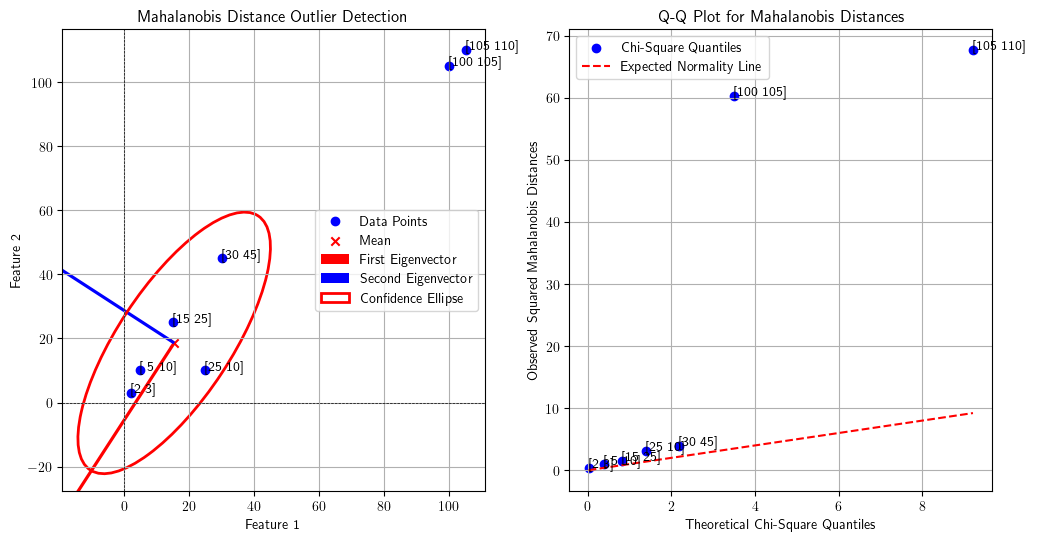

In [5]:
import numpy as np
from sklearn.covariance import MinCovDet

# each row is a sample and each column is a feature
X = np.array([[2,3],
              [5,10],
              [15,25],
              [25,10],
              [30,45],
              [100,105],  # Outlier
              [105,110]]) # Outlier

# Robust Covariance Estimation using Minimum Covariance Determinant (MCD)
# "MCD estimators can be seen as special cases of S-estimators where the function
# $\rho$ is 1".
h = (len(X) + 2 + 1) / 2
mcd = MinCovDet(support_fraction=h/len(X)).fit(X) # 5 out of 7 samples are inliers

# Compute Mahalanobis Distance
squared_mahalanobis_distances = mcd.mahalanobis(X)

# Chi-square threshold for p = 0.975 and df = 2 (since 2 features)
# which ensures that only 2.5% of the points are falsely flagged as outliers,
# assuming the dataset follows a multivariate normal distribution.
# The Mahalanobis distance follows a chi-square distribution with degrees of freedom
# equal to the number of features.
chi_square_threshold = chi2.ppf(0.975, df=2) # we are defining an ellipse that contains 97.5% of the data

print("chi-square threshold:", chi_square_threshold.round(2))
print("squared_mahalanobis_distances", squared_mahalanobis_distances.round(2))
print("outliers:", squared_mahalanobis_distances > chi_square_threshold)

# Eigenvalues and Eigenvectors for the ellipse orientation
# Eigenvalues are the variance of the data along the eigenvectors
# Eigenvectors are the direction of the variance
eigenvalues, eigenvectors = np.linalg.eig(mcd.covariance_)

# Sort Eigenvalues and Eigenvectors in descending order
order = eigenvalues.argsort()[::-1]
sorted_eigenvalues, sorted_eigenvectors = eigenvalues[order], eigenvectors[:, order]
print("sorted eigenvalues:", sorted_eigenvalues.round(2))
print("sorted eigenvectors:", sorted_eigenvectors.round(2))

# Compute the Angle for the ellipse orientation (in degrees)
# eigenvectors[:, 0] is the first principal component (direction of max variance)
# [::-1] flips from [x,y] to [y,x] because the angle is measured from the x-axis
# np.arctan2 gives the angle in radians, computes the angle relative to the x-axis
# np.degrees converts the angle to degrees
angle = np.degrees(np.arctan2(*sorted_eigenvectors[:, 0][::-1]))
print("angle:", angle)

# Eigenvalues are variances (squared units of spread)
# Taking the square root gives standard deviation, which is a measure of spread in the actual unit
# Multiplying by np.sqrt(chi2_square_threshold) scales the spread based on the chosen confidence level
# Multiplying by 2 emsures the ellipse covers the full width (from leftmost to rightmost point).
width, height = 2 * np.sqrt(chi_square_threshold * sorted_eigenvalues)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the data points
axes[0].scatter(X[:, 0], X[:, 1], label="Data Points", color='b')

# Highlight the mean center
inliers_mu = X[squared_mahalanobis_distances <= chi_square_threshold].mean(axis=0)
print("mu", mu)
print("inliers_mu:", inliers_mu)
axes[0].scatter(inliers_mu[0], inliers_mu[1], label="Mean", color='r', marker='x')

# Plot eigenvectors
# The new main X-axis of the data (rotated from the original X-axis)
axes[0].quiver(inliers_mu[0], inliers_mu[1], 
               sorted_eigenvectors[0, 0], sorted_eigenvectors[1, 0], 
               color='red', scale=1, label="First Eigenvector")

# The new secondary Y-axis of the data (rotated from the original Y-axis)
axes[0].quiver(inliers_mu[0], inliers_mu[1], 
               sorted_eigenvectors[0, 1], sorted_eigenvectors[1, 1], 
               color='blue', scale=1, label="Second Eigenvector")

# Add the confidence ellipse
ellipse = Ellipse(xy=inliers_mu, width=width, height=height, angle=angle, edgecolor='r', fc='None', linewidth=2, label="Confidence Ellipse")
axes[0].add_patch(ellipse)

# Annotate the data points
for i, txt in enumerate(X):
  axes[0].annotate(txt, (X[i, 0], X[i, 1]))

# Plot Settings
axes[0].axhline(y=0, color='black', linestyle="--", linewidth=0.5)
axes[0].axvline(x=0, color='black', linestyle="--", linewidth=0.5)
axes[0].set_xlabel("Feature 1")
axes[0].set_ylabel("Feature 2")
axes[0].set_title("Mahalanobis Distance Outlier Detection")
axes[0].legend()
axes[0].grid(True)

# Create Q-Q plot
# Check if dataset follows a chi-square distribution $d_M^2 \sim \chi^2$

## Compute squared Mahalanobis distances (should follow a chi-square distribution)
sorted_squared_mahalanobis_distances = np.sort(squared_mahalanobis_distances)

## Generate theoretical quantiles for the chi-square distribution
chi2_quantiles = chi2.ppf(np.linspace(0.01, 0.99, len(sorted_squared_mahalanobis_distances)), df=2)

axes[1].scatter(chi2_quantiles, sorted_squared_mahalanobis_distances, color='b', label="Chi-Square Quantiles")
axes[1].plot(chi2_quantiles, chi2_quantiles, linestyle='dashed', color='red', label="Expected Normality Line")

# Annotate the data points
for i, txt in enumerate(X):
  axes[1].annotate(txt, (chi2_quantiles[i], sorted_squared_mahalanobis_distances[i]))

# Labels and Title
axes[1].set_xlabel("Theoretical Chi-Square Quantiles")
axes[1].set_ylabel("Observed Squared Mahalanobis Distances")
axes[1].set_title("Q-Q Plot for Mahalanobis Distances")
axes[1].legend()
axes[1].grid(True)